In [1]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [3]:
def read_study_as_pcd(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
            series_desc = series_desc.split("/")[0]

        img = np.expand_dims(dicom_slice.pixel_array, -1)
        x, y, z = np.where(img)

        index_voxel = np.vstack((x, y, z))
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array))

        vals = np.expand_dims(img[x, y, z], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc in ("T2", "T2/STIR"):
            vals = np.pad(vals, ((0, 0), (1, 1)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals)  # Converted to np.float64

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )

        pcd_overall += pcd.transform(transform_matrix)

    return pcd_overall

In [4]:
read_study_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

PointCloud with 14784328 points.

In [5]:
def read_study_as_pcd_2(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = []
    vals_overall = []
    
    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
            series_desc = series_desc.split("/")[0]

        img = dicom_slice.pixel_array
        x, y = np.where(img)

        index_voxel = np.vstack((x, y, np.zeros(x.shape), np.full(x.shape, 1)))
        grid_index_array = index_voxel.T

        vals = np.expand_dims(img[x, y], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc in ("T2", "T2/STIR"):
            vals = np.pad(vals, ((0, 0), (1, 1)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )
        
        def apply_transform(v):
            return transform_matrix @ v.T
        
        pcd_overall.append(np.apply_along_axis(apply_transform, 1, grid_index_array))
        vals_overall.append(vals)
        
    return pcd_overall, vals_overall

In [6]:
read_study_as_pcd_2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)

KeyboardInterrupt: 

In [ ]:
def read_study_as_pcd_3(dir_path, series_types_dict=None, downsampling_factor=None):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        img = np.expand_dims(dicom_slice.pixel_array, -1)
        x, y, z = np.where(img)

        index_voxel = np.vstack((x, y, z))[:,::downsampling_factor]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        )

        pcd_overall += pcd.transform(transform_matrix)

    return pcd_overall

In [ ]:
pcd_1 = read_study_as_pcd_3("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs, 1)

o3d.visualization.draw_geometries([pcd_1])

In [ ]:
def read_study_as_voxel_grid_2(dir_path, series_type_dict=None, downsampling_factor=None):
    pcd_overall = read_study_as_pcd_3(dir_path, series_types_dict=series_type_dict, downsampling_factor=downsampling_factor)

    path = next(glob.iglob(os.path.join(dir_path, "**/*.dcm"), recursive=True))
    dicom_slice = dcmread(path)
    dX, dY = dicom_slice.PixelSpacing

    voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, dX)

    coords = []
    vals = []

    for voxel in voxel_grid.get_voxels():
        coords.append(voxel.grid_index)
        vals.append(voxel.color[:2])

    coords = np.array(coords)
    vals = np.array(vals, dtype=np.float16)

    size = np.max(coords, axis=0) + 1
    # 1 channel per pulse sequence type, CHWD (I think?)
    grid = np.zeros((2, size[0], size[1], size[2]), dtype=np.float16)

    grid[0, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 0]
    grid[1, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 1]

    del pcd_overall
    del voxel_grid

    return grid

In [6]:
grid_2 = read_study_as_voxel_grid_2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs, 3)

NameError: name 'read_study_as_pcd_3' is not defined

In [7]:
plt.imshow(grid_2[0, 160, :, :], cmap="gray")

NameError: name 'plt' is not defined

In [8]:
plt.imshow(F.adaptive_max_pool3d(torch.FloatTensor(grid_2), (128, 128, 128))[0, int(160/323*128)], cmap="gray")

NameError: name 'plt' is not defined

In [10]:
import cv2
import copy

def read_study_as_pcd_4(dir_path, series_types_dict=None, downsampling_factor=None, img_size=(256,256), ignore_thickness=True):
    pcd_overall = o3d.geometry.PointCloud()
    
    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
                
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]
                
        x_orig, y_orig = dicom_slice.pixel_array.shape
        img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
        x, y, z = np.where(img)
        
        index_voxel = np.vstack((x, y, z))[:,::downsampling_factor]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor], -1) / 256
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness
        
        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY
        
        if ignore_thickness:
            pos = list(dicom_slice.ImagePositionPatient)
            S = np.array(pos + [1])
                    
            transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T        
            transform_matrix = transform_matrix @ np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )
                
            pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)
        
        else:
            for z in range(int(dZ)):
                pos = list(dicom_slice.ImagePositionPatient)
                if series_desc == "T2":
                    pos[-1] += z
                else:
                    pos[0] += z
                S = np.array(pos + [1])
    
                transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T        
                transform_matrix = transform_matrix @ np.matrix(
                    [[0, y_orig / img_size[1], 0, 0],
                     [x_orig / img_size[0], 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]]
                )
    
                pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)



    return pcd_overall

In [13]:
pcd = read_study_as_pcd_4("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs, ignore_thickness=False)
o3d.visualization.draw_geometries([pcd])

In [23]:
def read_study_as_pcd_5(dir_path, series_types_dict=None, downsampling_factor=None, img_size=(256, 256)):
    pcd_overall = o3d.geometry.PointCloud()

    k_series = {}
    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))

        if (study_id, series_id) not in k_series:
            k_series[(study_id, series_id)] = [None, None]

        # Additional translation bits
        slice_index = int(path.split("/")[-1].split(".")[0])
        if k_series[(study_id, series_id)][0] is None and slice_index == 1:
            dicom_slice = dcmread(path)
            k_series[(study_id, series_id)][0] = dicom_slice.ImagePositionPatient
        elif k_series[(study_id, series_id)][1] is None or k_series[(study_id, series_id)][1][0] < slice_index:
            dicom_slice = dcmread(path)
            k_series[(study_id, series_id)][1] = (slice_index, dicom_slice.ImagePositionPatient)

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        
        slice_index = int(path.split("/")[-1].split(".")[0])
        
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
        x, y, z = np.where(img)

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor], -1) / 256
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        # for z in range(int(dZ)):
        #     pos = list(dicom_slice.ImagePositionPatient)
        #     if series_desc == "T2":
        #         pos[-1] += z
        #     else:
        #         pos[0] += z
        #     S = np.array(pos + [1])
        # 
        #     transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T        
        #     transform_matrix = transform_matrix @ np.matrix(
        #         [[0, y_orig / img_size[1], 0, 0],
        #          [x_orig / img_size[0], 0, 0, 0],
        #          [0, 0, 1, 0],
        #          [0, 0, 0, 1]]
        #     )
        #     
        #     pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

        pos = list(dicom_slice.ImagePositionPatient)
        S = np.array(pos + [1])

        k = np.array(k_series[(study_id, series_id)][1][1]) - np.array(k_series[(study_id, series_id)][0])
        k = k / (k_series[(study_id, series_id)][1][0] - 1)
        k = np.concatenate((k, np.array([0])))

        transform_matrix = np.array([X, Y, k, S]).T
        transform_matrix = transform_matrix @ np.matrix(
            [[0, y_orig / img_size[1], 0, 0],
             [x_orig / img_size[0], 0, 0, 0],
             [0, 0, 1, slice_index],
             [0, 0, 0, 1]]
        )

        pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

    return pcd_overall

In [24]:
pcd = read_study_as_pcd_5("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/",
                          series_descs)
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [31]:
def read_study_as_voxel_grid(dir_path, series_type_dict=None, downsampling_factor=None, img_size=(128, 128)):
    pcd_overall = read_study_as_pcd_4(dir_path, series_types_dict=series_type_dict, downsampling_factor=downsampling_factor, img_size=img_size)

    path = next(glob.iglob(os.path.join(dir_path, "**/*.dcm"), recursive=True))
    dicom_slice = dcmread(path)
    dX, dY = dicom_slice.PixelSpacing

    size = dicom_slice.pixel_array.shape[0] / img_size[0]
    size = max(size, dicom_slice.pixel_array.shape[1] / img_size[1])
    
    voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, 0.3)
    
    coords = []
    vals = []
    
    for voxel in voxel_grid.get_voxels():
        coords.append(voxel.grid_index)
        vals.append(voxel.color)
    
    coords = np.array(coords)
    vals = np.array(vals, dtype=np.float16)

    size = np.max(coords, axis=0) + 1
    # 1 channel per pulse sequence type, CHWD (I think?)
    grid = np.zeros((3, size[0], size[1], size[2]), dtype=np.float16)

    grid[0, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 0]
    grid[1, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 1]
    grid[2, coords[:, 0], coords[:, 1], coords[:, 2]] = vals[:, 2]

    del pcd_overall
    del voxel_grid

    return grid

In [32]:
grid = read_study_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs)
grid.shape

(3, 530, 629, 885)

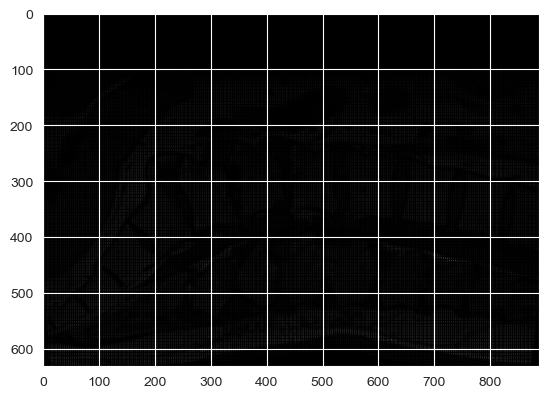

In [30]:
import matplotlib.pyplot as plt

plt.imshow(grid[0, 265, :, :], cmap="gray")

In [ ]:
plt.imshow(tio.ZNormalization()(torch.FloatTensor(grid).squeeze(0))[0, 250], cmap="gray")

In [ ]:
plt.imshow(F.adaptive_max_pool3d(torch.FloatTensor(grid).unsqueeze(0), (192, 192, 192))[0, 0, 96], cmap="gray")

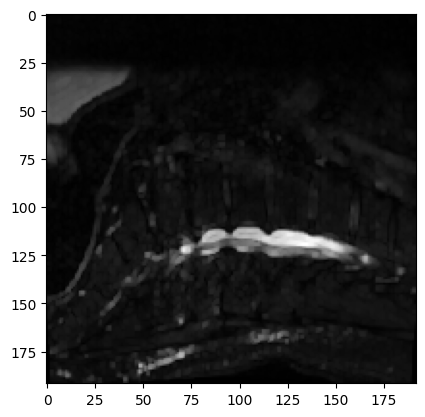

In [136]:
import torch.nn.functional as F

plt.imshow(F.adaptive_max_pool3d(torch.FloatTensor(grid).unsqueeze(0), (192, 192, 192))[0, 2, 96], cmap="gray")

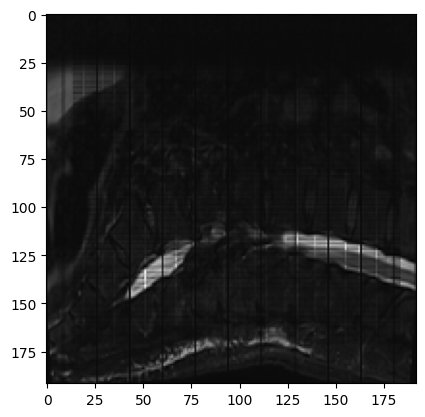

In [100]:
plt.imshow(tio.Resize((192, 192, 192), image_interpolation="bspline")(torch.FloatTensor(grid).squeeze(0))[2, 96], cmap="gray")

In [99]:
box = pcd.get_axis_aligned_bounding_box()

NameError: name 'pcd' is not defined

In [79]:
box.center, box.extent

(array([-2.38287776e-03,  4.07281935e+01,  2.26109423e+01]),
 array([271.66664015, 196.28336981, 172.99230682]))

In [161]:
o3d.visualization.draw_geometries([pcd_a])

In [48]:
def read_study_as_voxel_grid_2(dir_path, series_type_dict=None, downsampling_factor=None, img_size=(256, 256)):
    pcd_overall = read_study_as_pcd_4(dir_path, series_types_dict=series_type_dict, downsampling_factor=downsampling_factor, img_size=img_size, ignore_thickness=False)
    box = pcd_overall.get_axis_aligned_bounding_box()
    
    x_min, y_min, z_min = box.get_max_bound()
    x_max, y_max, z_max = box.get_min_bound()

    max_b = np.array(box.get_max_bound())
    min_b = np.array(box.get_min_bound())
    
    pts = (np.array(pcd_overall.points) - (min_b)) * ((img_size[0] - 1, img_size[0] - 1, img_size[0] - 1) / (max_b - min_b))
    coords = np.round(pts).astype(np.int32)
    vals = np.array(pcd_overall.colors, dtype=np.float16)

    grid = np.zeros((3, img_size[0], img_size[0], img_size[0]), dtype=np.float16)
    for i, c in enumerate(coords):
        x, y, z = c    
        
        grid[0, x, y, z] = max(grid[0, x, y, z], vals[i, 0])
        grid[1, x, y, z] = max(grid[1, x, y, z], vals[i, 1])
        grid[2, x, y, z] = max(grid[2, x, y, z], vals[i, 2])

    return grid

In [49]:
grid = read_study_as_voxel_grid_2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/", series_descs, img_size=(128, 128))

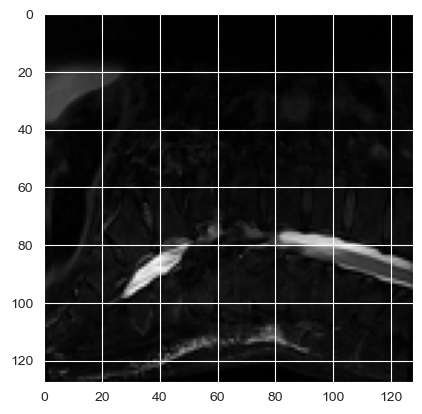

In [54]:
import matplotlib.pyplot as plt
import cv2

plt.imshow(grid[2, 64, :, :], cmap="gray")

In [1]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

grid = read_study_as_voxel_grid_v2("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/46494080", series_type_dict=series_descs, img_size=(256,256))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [2]:
grid.shape

(3, 256, 256, 256)

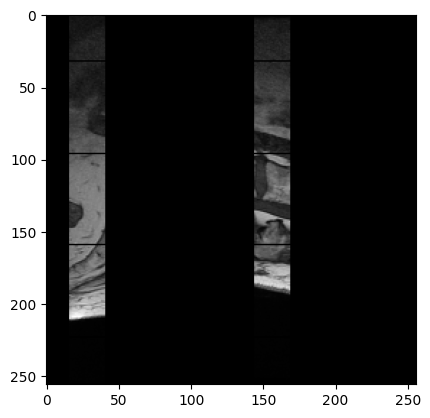

In [7]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# test = F.adaptive_max_pool3d(torch.FloatTensor(grid).unsqueeze(0), (192, 192, 192))
plt.imshow(grid[0, 126, :], cmap = "gray")

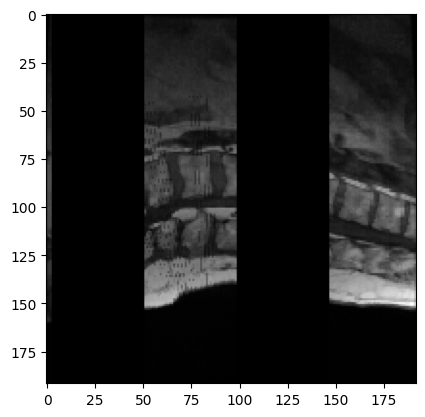

In [61]:
import torchio as tio

plt.imshow(tio.Resize((192, 192, 192), image_interpolation="bspline")(torch.FloatTensor(test).squeeze(0))[0, 96], cmap="gray")

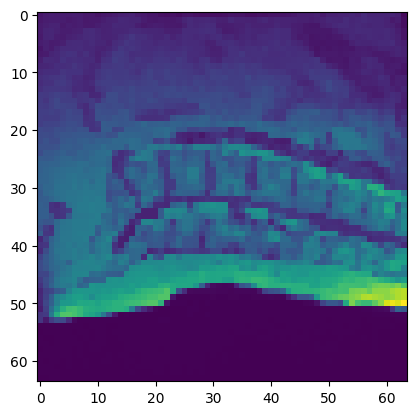

In [10]:
test_2 = F.adaptive_max_pool3d(torch.FloatTensor(grid).unsqueeze(0), (64, 64, 64))
plt.imshow(test_2[0, 0, 32])

In [ ]:
test_3 = F.adaptive_avg_pool3d(torch.tensor(grid).unsqueeze(0), (48, 48, 48))
plt.imshow(test_2[0, 1, 24])

In [6]:
import pgzip
import numpy as np

f = pgzip.PgzipFile("D:\\Users\\Victor\\Documents\\python-doodles\\data\\rsna-2024-lumbar-spine-degenerative-classification\\train_images\\408455883\\cached_grid_down3.npy.gz", "r")
test_1 = np.load(f)
f.close()

f = pgzip.PgzipFile("D:\\Users\\Victor\\Documents\\python-doodles\\data\\rsna-2024-lumbar-spine-degenerative-classification\\train_images\\408455883\\cached_grid_3chan_down3.npy.gz", "r")
test_2 = np.load(f)
f.close()

In [7]:
print(test_1.shape, test_2.shape)

(2, 303, 384, 389) (3, 303, 384, 389)


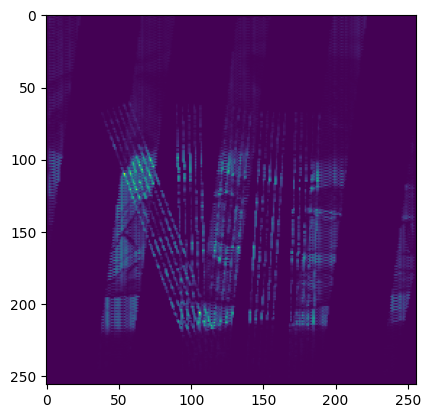

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

test_1_ = F.adaptive_avg_pool3d(torch.tensor(test_1).unsqueeze(0), (256, 256, 256))
plt.imshow(test_1_[0, 1, 128])

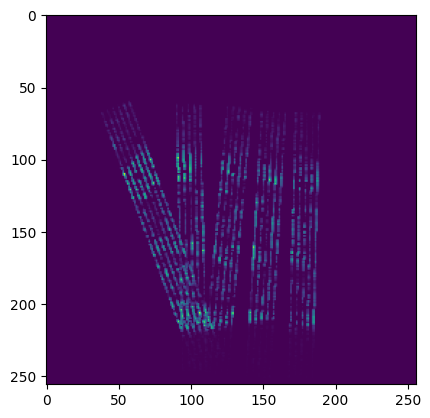

In [9]:
test_2_ = F.adaptive_avg_pool3d(torch.tensor(test_2).unsqueeze(0), (256, 256, 256))
plt.imshow(test_2_[0, 1, 128])

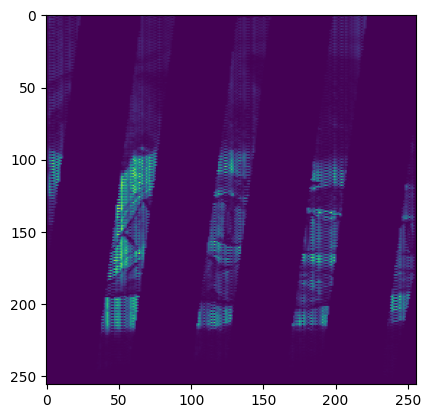

In [10]:
plt.imshow(test_2_[0, 2, 128])

In [31]:
grid = read_vertebral_level_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/46494080",
                                          vertebral_level="test",
                                          min_bound=np.array([-60, -60, -60]),
                                          max_bound=np.array([60, 60, 60]),
                                          series_type_dict=series_descs)

KeyboardInterrupt: 

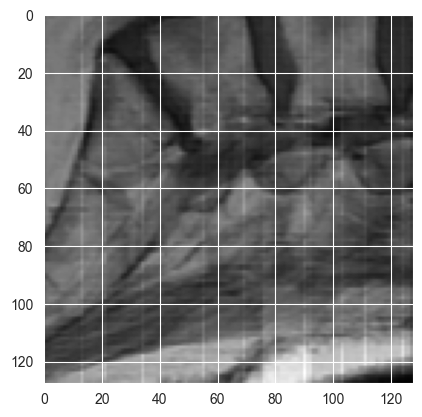

In [31]:
plt.imshow(np.sum(grid[0, 50:80], axis=0), cmap="gray")

In [58]:
coords = pd.read_csv("../data/lumbar-coordinate-pretraining-dataset/coords_3d.csv")
coords

,study_id,level,x,y,z
0,4003253,L1/L2,2.281485,74.681099,-389.679551
1,4003253,L2/L3,2.503593,73.621785,-421.436447
2,4003253,L3/L4,2.750310,74.774676,-457.109285
3,4003253,L4/L5,2.924442,80.522574,-483.128617
4,4003253,L5/S1,3.098990,89.018362,-509.676647
...,...,...,...,...,...
9865,4290709089,L1/L2,10.407222,74.543790,-347.122554
9866,4290709089,L2/L3,9.814853,64.679538,-380.458776
9867,4290709089,L3/L4,9.187656,61.836557,-413.573176
9868,4290709089,L4/L5,8.589401,67.148507,-442.856477


In [21]:
bounding_boxes = pd.read_csv("../data/lumbar-coordinate-pretraining-dataset/bounding_boxes_3d.csv")
bounding_boxes

,study_id,level,x_min,y_min,z_min,x_max,y_max,z_max
0,4003253,L1/L2,-61.232307,11.167308,-400.265183,65.795276,138.194891,-379.093919
1,4003253,L2/L3,-61.010199,10.107994,-432.022079,73.849269,144.967462,-409.545501
2,4003253,L3/L4,-68.595366,3.429000,-469.000231,54.788974,126.813340,-448.436174
3,4003253,L4/L5,-49.114223,28.483910,-491.801728,56.020502,133.618634,-474.279274
4,4003253,L5/S1,-49.997070,35.922302,-536.224677,56.195050,142.114422,-500.827304
...,...,...,...,...,...,...,...,...
9865,4290709089,L1/L2,-56.265220,7.871348,-358.234628,77.079664,141.216232,-336.010481
9866,4290709089,L2/L3,-56.857589,-1.992904,-391.570849,76.043655,130.908340,-369.420642
9867,4290709089,L3/L4,-57.041146,-4.392245,-424.611310,67.754256,120.403158,-403.812076
9868,4290709089,L4/L5,-49.977199,8.581907,-452.617577,61.993295,120.552402,-433.955828


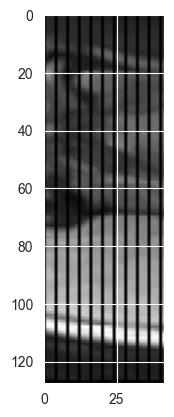

In [35]:
row = bounding_boxes.iloc[5]
# row = coords.iloc[0]

grid = read_vertebral_level_as_voxel_grid(
    f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
    vertebral_level=row['level'].replace("/", "").lower(),
    min_bound=np.array([row['x_min'], row['y_min'], row['z_min']]),
    max_bound=np.array([row['x_max'], row['y_max'], row['z_max']]),
    # min_bound=np.array([row['x'] - 100, row['y'] - 50, row['z'] - 100]),
    # max_bound=np.array([row['x'] + 100, row['y'] + 50, row['z'] + 100]),
    series_type_dict=series_descs,
    voxel_size=(128,128,int(128/3)),
    caching=False)

plt.imshow(np.max(grid[0, 62:66], axis=0), cmap="gray")

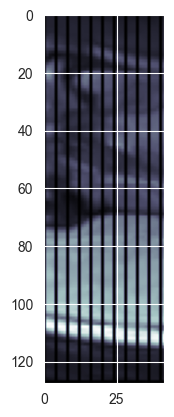

In [53]:
plt.imshow(np.max(grid[0, 62:66], axis=0), cmap="bone")


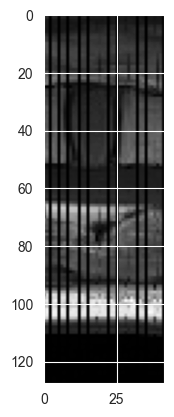

In [34]:
row = bounding_boxes.iloc[1]
# row = coords.iloc[0]

grid = read_vertebral_level_as_voxel_grid(
    f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
    vertebral_level=row['level'].replace("/", "").lower(),
    min_bound=np.array([row['x_min'], row['y_min'], row['z_min']]),
    max_bound=np.array([row['x_max'], row['y_max'], row['z_max']]),
    # min_bound=np.array([row['x'] - 100, row['y'] - 50, row['z'] - 100]),
    # max_bound=np.array([row['x'] + 100, row['y'] + 50, row['z'] + 100]),
    series_type_dict=series_descs,
    voxel_size=(128,128,int(128/3)),
    caching=False)

plt.imshow(np.max(grid[0, 62:66], axis=0), cmap="gray")

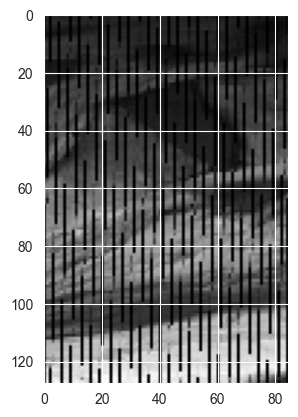

In [82]:
row = bounding_boxes.iloc[29]
# row = coords.iloc[0]

grid = read_vertebral_level_as_voxel_grid(
    f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
    vertebral_level=row['level'].replace("/", "").lower(),
    min_bound=np.array([row['x_min'], row['y_min'], row['z_min']]),
    max_bound=np.array([row['x_max'], row['y_max'], row['z_max']]),
    # min_bound=np.array([row['x'] - 100, row['y'] - 50, row['z'] - 100]),
    # max_bound=np.array([row['x'] + 100, row['y'] + 50, row['z'] + 100]),
    series_type_dict=series_descs,
    voxel_size=(128, 128, int(128/3 * 2)),
    caching=True)

plt.imshow(np.max(grid[0, 47:56], axis=0), cmap="gray")

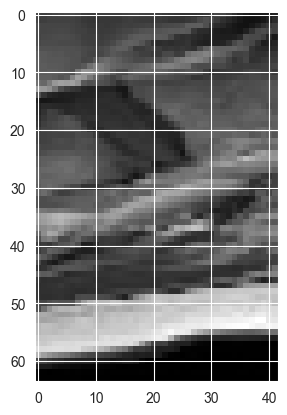

In [69]:
grid_2 = read_vertebral_level_as_voxel_grid(
    f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
    vertebral_level=row['level'].replace("/", "").lower(),
    min_bound=np.array([row['x_min'], row['y_min'], row['z_min']]),
    max_bound=np.array([row['x_max'], row['y_max'], row['z_max']]),
    # min_bound=np.array([row['x'] - 100, row['y'] - 50, row['z'] - 100]),
    # max_bound=np.array([row['x'] + 100, row['y'] + 50, row['z'] + 100]),
    series_type_dict=series_descs,
    voxel_size=(64, 64, int(64 / 3 * 2)),
    caching=False)

plt.imshow(np.mean(grid_2[0, 23:29], axis=0), cmap="gray")

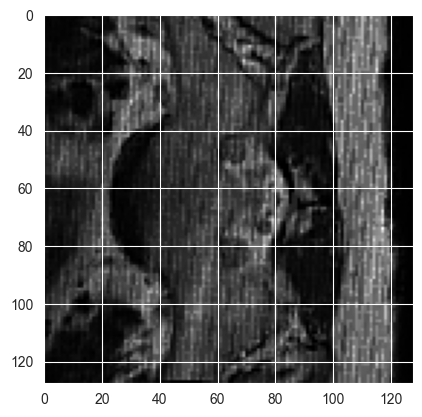

In [71]:
plt.imshow(np.mean(grid[1, :, :, 10:18], axis=2), cmap="gray")


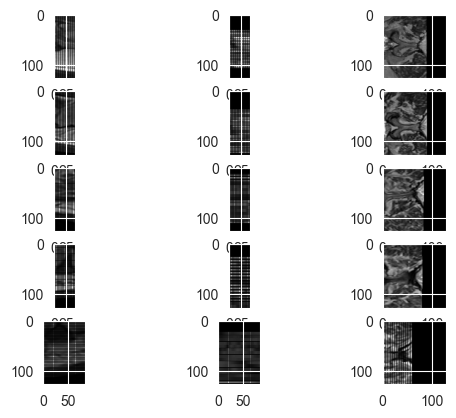

In [33]:
f, axs = plt.subplots(5, 3)

for i in range(5,10):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
    grid = read_vertebral_level_as_voxel_grid(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
        vertebral_level=level,
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(128, 128, int(128 / 3) if level != "l5s1" else int(128 / 3 * 2)),
        caching=False)
    
    if level == "l5s1":
        mid = 42
    else:
        mid = 21
    
    axs[i - 5, 0].imshow(np.max(grid[0, 62:66], axis=0), cmap="gray")
    axs[i - 5, 1].imshow(np.max(grid[0, :, 62:66], axis=1), cmap="gray")
    axs[i - 5, 2].imshow(np.max(grid[1, :, :, mid-6:mid+6], axis=2), cmap="gray")
    
plt.show()